# 1. Setup Mario
Basic mario environment setup, with random actions.

In [1]:
from nes_py.wrappers import JoypadSpace
import gym
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT


In [8]:

env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

done = True
for step in range(2000):
    if done:
       state = env.reset()
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
env.close()

d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# 2. Preprocessing Data

## 2.1 What the environment is giving us

In [4]:
# Number of possible actions the AI can make
env.action_space

Discrete(7)

In [5]:
# The format returned by the environment : A colored frame
env.observation_space.shape

(240, 256, 3)

## 2.2 What we want
- Turn the image into grayscale
- Save a stack of 4 images to give context to the model

In [9]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
%pip install stable-baselines3[extra]
%pip install matplotlib

^C
Note: you may need to restart the kernel to use updated packages.


In [7]:
from nes_py.wrappers import JoypadSpace
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)
import gym
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from matplotlib import pyplot as plt

In [2]:
FRAME_STACK_SIZE = 4

Basic environment

In [13]:
# Base environment
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True)
# Simplify controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale observation
env = GrayScaleObservation(env, keep_dim=True)
# Wrap inside the dummy vector environment
env = DummyVecEnv([lambda: env])
# Stack 4 frames
env = VecFrameStack(env, n_stack=FRAME_STACK_SIZE, channels_order='last')

d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Multiprocessed environment

In [3]:
env_id = "SuperMarioBros-v0"
num_processes = 8

In [5]:
def make_env(env_id: str, rank: int, seed: int = None):
    """
    Utility function for multiprocessed env.

    :param env_id: the environment ID
    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the inital seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        env = gym.make(env_id, apply_api_compatibility=True)
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        env = GrayScaleObservation(env, keep_dim=True)
        return env
    return _init

In [6]:
# Create n environments
env = DummyVecEnv([make_env(env_id, i) for i in range(num_processes)])
# Stack 4 frames
env = VecFrameStack(env, n_stack=FRAME_STACK_SIZE, channels_order='last')

d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [7]:
state = env.reset()
state[0].shape

(240, 256, 4)

In [21]:
action = env.action_space.sample()
state, reward, done, info = env.step([action])

d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


IndexError: list index out of range

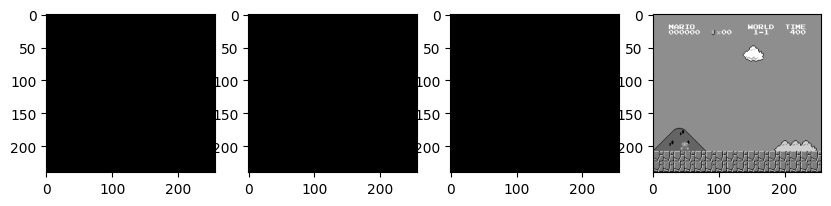

In [22]:
# show the 4 current frames
plt.figure(figsize=(10, 8))
for idk in range(state.shape[3]):
    plt.subplot(1, 4, idk + 1)
    plt.imshow(state[0, :, :, idk], cmap='gray')
plt.show()

# 3. Training the model

In [4]:
import os
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [9]:
# class to automatically save models while training
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            self.model.save(os.path.join(self.save_path, f"model_{self.n_calls * num_processes}"))
        
        return True

In [5]:
CHECKPOINT_DIR = "./train"
LOG_DIR = "./logs"

In [11]:
# setup the callback
callback = TrainAndLoggingCallback(check_freq=10000 / num_processes, save_path=CHECKPOINT_DIR)

In [13]:
# create the model
model = PPO("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, n_steps=512)

# train the model
model.learn(total_timesteps=1000000, callback=callback)

Using cuda device
Wrapping the env in a VecTransposeImage.
Logging to ./logs\PPO_4
-----------------------------
| time/              |      |
|    fps             | 302  |
|    iterations      | 1    |
|    time_elapsed    | 13   |
|    total_timesteps | 4096 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 122          |
|    iterations           | 2            |
|    time_elapsed         | 66           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0009067947 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.000967    |
|    learning_rate        | 1e-06        |
|    loss                 | 93.7         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000532    |
|    value_loss    

In [14]:
model_name = "Mario-1M"
model.save(f"./saved_models/{model_name}")

d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\stable_baselines3\common\save_util.py:283: UserWarning: Path 'saved_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


# 4. Testing the model

In [8]:
# Base environment
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
# Simplify controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# Grayscale observation
env = GrayScaleObservation(env, keep_dim=True)
# Wrap inside the dummy vector environment
env = DummyVecEnv([lambda: env])
# Stack 4 frames
env = VecFrameStack(env, n_stack=FRAME_STACK_SIZE, channels_order='last')

d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
d:\Documents\E5e\Reinforced-Mario\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [10]:
# load the model
model = PPO.load(os.path.join(CHECKPOINT_DIR, "model_120000.zip"), env=env)

Wrapping the env in a VecTransposeImage.


In [9]:
# load a saved model
model = PPO.load(os.path.join("./saved_models", "Mario-1M.zip"), env=env)

Wrapping the env in a VecTransposeImage.


In [11]:
# start the game with the trained model
state = env.reset()
for i in range(10000):
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()
env.close()

KeyboardInterrupt: 

: 